In [78]:
import pandas as pd
import requests
import os    
import glob
import os

# Данные Binance

Загружаем данные по трейдам с бинанса

In [206]:
BINANCE_TRADES_DIR = "binance/trades"

def download_trades(pair="XTZUSDT"):
    months = [
        ("2022", "04"),
        ("2022", "03"),
        ("2022", "02"),
        ("2022", "01"),
        ("2021", "12"),
        ("2021", "11"),
        ("2021", "10"),
        ("2021", "09"),
        ("2021", "08"),
        ("2021", "07"),
        ("2021", "06"),
        ("2021", "05"),
        ("2021", "04"),
    ]
    url_prefix = f"https://data.binance.vision/data/spot/monthly/trades/{pair}/{pair}-trades-"
    for year, month in months:
        url_suffix = f"{year}-{month}.zip"
        url = url_prefix + url_suffix
        r = requests.get(url)
        open(f'{BINANCE_TRADES_DIR}/{pair}-trades-{year}-{month}.zip', 'wb').write(r.content)

def merge_csv(pair):
    from zipfile import ZipFile

    for (dirpath, dirnames, filenames) in os.walk(BINANCE_TRADES_DIR):
        for filename in filenames:
            if filename.endswith('.zip'): 
                print(filename)
                zf = ZipFile(f'{BINANCE_TRADES_DIR}/{filename}', 'r')
                zf.extractall(f'{BINANCE_TRADES_DIR}')
                zf.close()

    files = f"{BINANCE_TRADES_DIR}/{pair}*.csv"
    # list of merged files returned
    files = glob.glob(files)

    # joining files with concat and read_csv
    df = pd.concat(map(lambda x: pd.read_csv(x, header=None, names=[
            "tradeId","price","qty","quoteQty","time","isBuyerMaker", "kek"
        ]), files), ignore_index=True)
    print(df.head())
    
    df = df.drop(columns=["kek"])
    
    df = df.sort_values(by="time", ignore_index=True)
    df.to_csv(f"{BINANCE_TRADES_DIR}/{pair}.csv", index=False)

In [209]:
if not os.path.exists(BINANCE_TRADES_DIR):
    os.makedirs(BINANCE_TRADES_DIR)

# download_trades("XTZBTC")
merge_csv("XTZBTC")

XTZUSDT-trades-2022-01.zip
XTZUSDT-trades-2022-03.zip
XTZUSDT-trades-2022-02.zip
XTZBTC-trades-2021-09.zip
XTZBTC-trades-2021-08.zip
XTZUSDT-trades-2022-04.zip
XTZBTC-trades-2022-01.zip
XTZBTC-trades-2022-02.zip
XTZBTC-trades-2022-03.zip
XTZUSDT-trades-2021-08.zip
XTZUSDT-trades-2021-09.zip
XTZBTC-trades-2022-04.zip
XTZUSDT-trades-2021-07.zip
XTZUSDT-trades-2021-06.zip
XTZUSDT-trades-2021-12.zip
XTZUSDT-trades-2021-04.zip
XTZUSDT-trades-2021-10.zip
XTZUSDT-trades-2021-11.zip
XTZUSDT-trades-2021-05.zip
XTZBTC-trades-2021-06.zip
XTZBTC-trades-2021-12.zip
XTZBTC-trades-2021-07.zip
XTZBTC-trades-2021-11.zip
XTZBTC-trades-2021-05.zip
XTZBTC-trades-2021-04.zip
XTZBTC-trades-2021-10.zip
    tradeId     price     qty  quoteQty           time  isBuyerMaker   kek
0  16742108  0.000073   12.00  0.000880  1627776004359         False  True
1  16742109  0.000073    1.20  0.000088  1627776004359         False  True
2  16742110  0.000073    4.50  0.000330  1627776006181         False  True
3  16742111

In [102]:
df.head()

,tradeId,price,qty,quoteQty,time,isBuyerMaker
0,30702821,4.8262,2.41,11.631142,1617235203734,True
1,30702822,4.8307,8.09,39.080363,1617235206852,False
2,30702823,4.8308,33.12,159.996096,1617235208630,False
3,30702824,4.8321,2.62,12.660102,1617235208654,False
4,30702825,4.8341,202.88,980.742208,1617235208906,False


# Данные Tezos


### Загрузка 

In [ ]:
import requests
import pandas as pd

COLUMNS = [
    "id",
    "hash",
    "time",
    "op_n",
    "op_p",
    "status",
    "gas_limit",
    "gas_used",
    "volume",
    "fee",
    # "data",
    "parameters",
    "storage",
    "errors",
    "sender",
    "receiver",
    "block",
    "entrypoint"
]


CONTRACTS = [
    'KT1WBLrLE2vG8SedBqiSJFm4VVAZZBytJYHc', # tzBTC
    'KT1WxgZ1ZSfMgmsSDDcUn8Xn577HwnQ7e1Lb', # USDtz
    'KT1Evsp2yA19Whm24khvFPcwimK6UaAJu8Zo', # ETHtz
    'KT1K4EwTpbvYN9agJdjpyJm4ZZdhpUNKB3F6', # kUSD
    'KT1EtjRRCBC2exyCRXz8UfV7jz7svnkqi7di', # uUSD
    'KT1FbYwEWU8BTfrvNoL5xDEC5owsDxv9nqKT', # ctez

    # PLENTY
    'KT1TnsQ6JqzyTz5PHMsGj28WwJyBtgc146aJ', # kUSD-USDtz

    'KT1X1nkqJDR1UHwbfpcnME5Z7agJLjUQNguB', # ctez - kUSD
    'KT1PWAXfPatPWBNJUxTHin4ECin1kYJHHnsr', # ctez - USDtz
    'KT1GSYhwanehtwCK3NPfkMFbD1bNQmvosbqL', # ctez - ETHtz
    'KT1Rx3pQzsn4FBuuYhcWsqUS7vWFx3ktqSWD', # ctez - uUSD
    'KT1Wryxte8NnVCm569yb8dcSPmvFBVs4ufD6', # ctez - tzBTC
    
    # liquidity baking
    'KT1TxqZ8QtKvLu3V3JH7Gx58n7Co8pgtpQU5', 
    
    # vortex
    'KT1V1ea4Rpb8AJJkmAtBpg1VRNyfLcFFZM6d', # ETHtz
    'KT1Wjadao8AXkwNQmjstbPGtLd1ZrUyQEDX7', # kUSD
    'KT1DDWpBTgqMtkdnB5W17n47MDGrKyWBbQEB', # BTCtz
    'KT1ND1bkLahTzVUt93zbDtGugpWcL23gyqgQ', # uUSD
    'KT19HdcBJw8XJkDYKLr6ez9KkhhuS8MYUdcs', # USDtz
    'KT1MRMsyWYCwf2ex2wN4yuihJbNykCDHdRTT', # ctez
]

rows = []

import pytezos as pytez

for contract_address in CONTRACTS:

    contract = pytez.pytezos.using('mainnet').contract(contract_address)
    storage = contract.storage

    def process_parameters(parameters_str, entrypoint_name):
        if not parameters_str:
            return None
        parameters_bytes = bytes.fromhex(parameters_str)
        return contract.entrypoints[entrypoint_name].from_micheline_value(pytez.unforge_micheline(parameters_bytes))

    def process_storage(storage_str):
        if not storage_str:
            return None
        try:
            storage_bytes = bytes.fromhex(str(storage_str))
            res = storage.decode(pytez.unforge_micheline(storage_bytes))
        except Exception as e:
            return None
        return str(res)

    last_cursor = None
    while True:
        stop = True
        try:
            with requests.session() as session:
                while True:
                    request_params = {
                        "type":"transaction",
                        "is_contract":1,
                        "limit": 1000,
                        "receiver": contract_address,
                        "columns": ",".join(COLUMNS)
                    }
                    if last_cursor:
                        request_params["cursor"] = last_cursor
                    response = session.get(
                        "https://api.tzstats.com/tables/op.json",
                        params=request_params
                    ).json()
                    
                    if len(response) == 0:
                        break
                    for row in response:
                        # row[10] = process_parameters(row[10], row[len(row) - 1])
                        row[11] = process_storage(row[11])

                    rows.extend(response)
                    last_cursor = response[len(response) - 1][0]
                    print(last_cursor)
        except Exception as e:
            print(e.what())
            stop = False
        if stop:
            break

data = pd.DataFrame(rows, columns=COLUMNS)
data.to_csv("data.csv", header=True)
        

### Достать  XTZ-kUSD

In [210]:
import matplotlib.pyplot as plt

In [227]:
data = pd.read_csv("tezos/data.csv")

In [228]:
data.groupby("receiver")["volume"].sum().sort_values()

receiver
KT1PWAXfPatPWBNJUxTHin4ECin1kYJHHnsr    0.000000e+00
KT1Wryxte8NnVCm569yb8dcSPmvFBVs4ufD6    0.000000e+00
KT1TnsQ6JqzyTz5PHMsGj28WwJyBtgc146aJ    0.000000e+00
KT1Rx3pQzsn4FBuuYhcWsqUS7vWFx3ktqSWD    0.000000e+00
KT1GSYhwanehtwCK3NPfkMFbD1bNQmvosbqL    0.000000e+00
KT1X1nkqJDR1UHwbfpcnME5Z7agJLjUQNguB    0.000000e+00
KT1DDWpBTgqMtkdnB5W17n47MDGrKyWBbQEB    5.626516e+04
KT1ND1bkLahTzVUt93zbDtGugpWcL23gyqgQ    2.451746e+05
KT1V1ea4Rpb8AJJkmAtBpg1VRNyfLcFFZM6d    3.311549e+05
KT1WBLrLE2vG8SedBqiSJFm4VVAZZBytJYHc    7.371495e+05
KT1Wjadao8AXkwNQmjstbPGtLd1ZrUyQEDX7    8.221542e+05
KT1FbYwEWU8BTfrvNoL5xDEC5owsDxv9nqKT    9.563968e+05
KT19HdcBJw8XJkDYKLr6ez9KkhhuS8MYUdcs    1.034719e+06
KT1MRMsyWYCwf2ex2wN4yuihJbNykCDHdRTT    1.881980e+06
KT1EtjRRCBC2exyCRXz8UfV7jz7svnkqi7di    2.001419e+06
KT1Evsp2yA19Whm24khvFPcwimK6UaAJu8Zo    2.353809e+06
KT1WxgZ1ZSfMgmsSDDcUn8Xn577HwnQ7e1Lb    5.899189e+06
KT1K4EwTpbvYN9agJdjpyJm4ZZdhpUNKB3F6    1.550901e+07
KT1TxqZ8QtKvLu3V3JH7Gx58n7Co8pgtpQU5 

In [229]:
pair = "XTZ_tzBTC"
pair_data = data[data["receiver"] == "KT1TxqZ8QtKvLu3V3JH7Gx58n7Co8pgtpQU5"] 

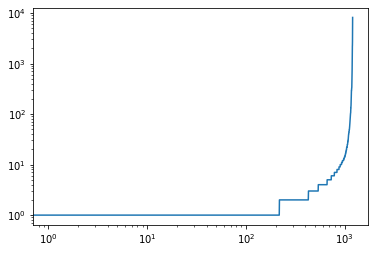

In [230]:
plt.plot(pair_data.groupby("sender").count()["id"].sort_values().to_numpy())
plt.xscale("log")
plt.yscale("log")

In [231]:
pair_data = pair_data.sort_values(by="time")

In [232]:
pair_data = pair_data.drop(columns=["Unnamed: 0"])

In [236]:
import json

def storage_to_cols(row):
    print(row)
    return row
    
def unpack_storage_quipuswap(df):
    df["token_pool"] = "-1"
    df["tez_pool"] = "-1"
    for index, row in df.iterrows():
        try:
            storage = json.loads(row["storage"].replace("'", "\"").replace("None", "null"))
        except Exception as e:
            continue
            
        df.loc[index, "token_pool"] = (storage["storage"]["token_pool"]) / 10**18
        df.loc[index, "tez_pool"] = (storage["storage"]["tez_pool"]) / 10**6
    return df
    
    
def unpack_storage_liquidity_baking(df):
    df["token_pool"] = "-1"
    df["tez_pool"] = "-1"
    for index, row in df.iterrows():
        try:
            storage = json.loads(row["storage"].replace("'", "\"").replace("None", "null"))
        except Exception as e:
            continue
        df.loc[index, "token_pool"] = (storage["tokenPool"]) / 10**8
        df.loc[index, "tez_pool"] = (storage["xtzPool"]) / 10**6
    
    return df

pair_data = unpack_storage_liquidity_baking(pair_data)

In [237]:
pair_data = pair_data.drop(columns=["storage", "receiver", "parameters", "errors"])

In [238]:
pair_data.to_csv("tezos/XTZ_tzBTC.csv", sep=" ")

# Аналитика истории цены

In [244]:
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

In [239]:
price_history = pd.read_csv("data/price-history.csv")

In [254]:
price_history["time"] = pd.to_datetime(price_history["timestamp"] * 1000000)

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


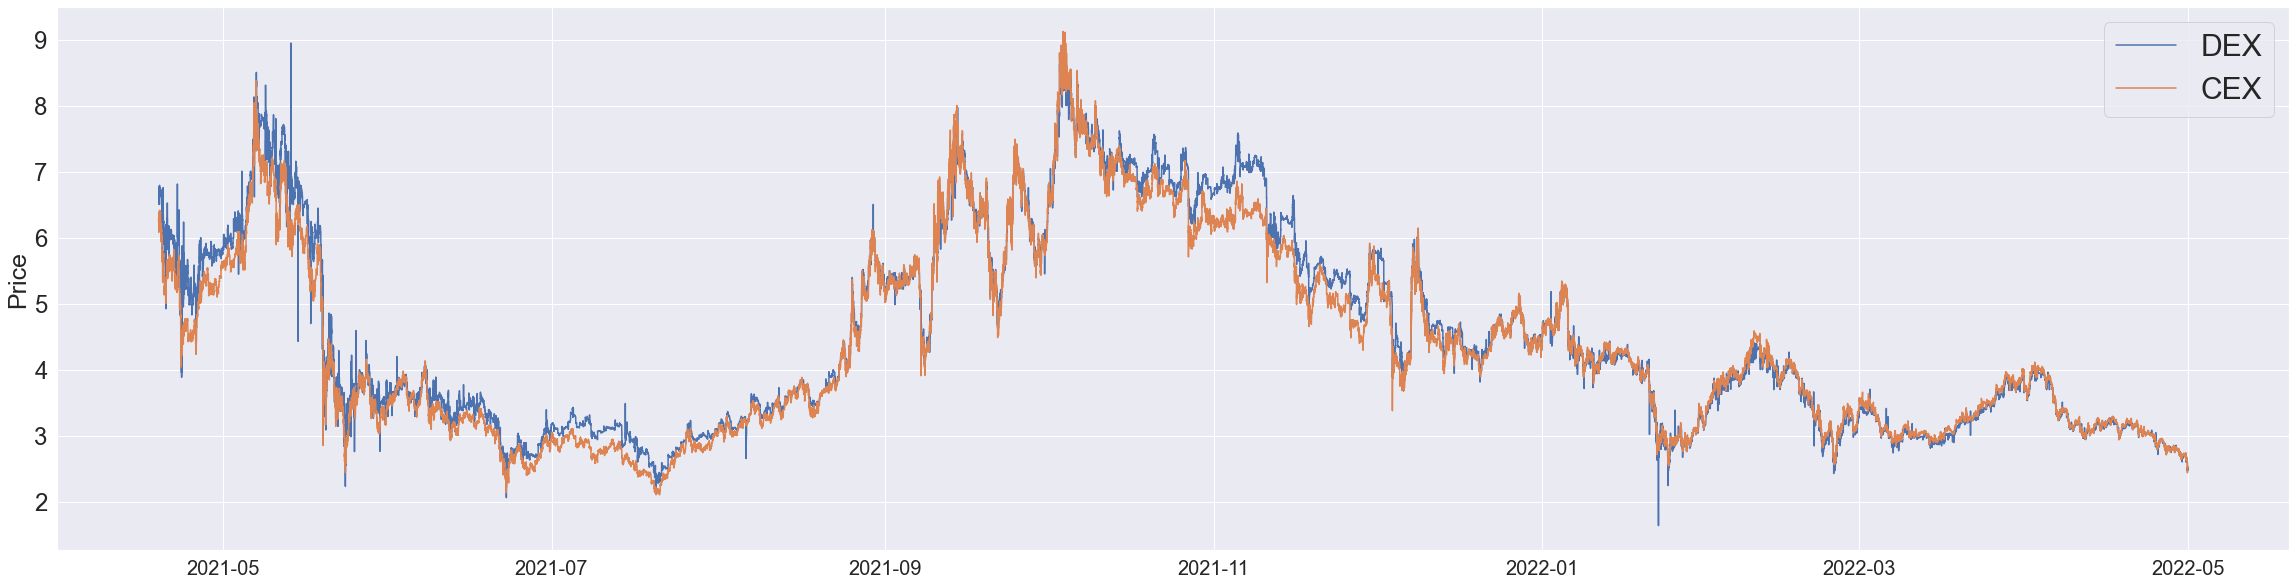

In [268]:
plt.rcParams['figure.figsize'] = [40, 10]
ax = sns.lineplot(price_history["time"], price_history["dex"], label="DEX")
ax = sns.lineplot(price_history["time"], price_history["cex"], label="CEX")
plt.setp(ax.get_xticklabels(), rotation=0, size=20)
plt.setp(ax.get_yticklabels(), size=24)
plt.xlabel("", size=20)
plt.ylabel("Price", size=25)
plt.legend(prop={'size': 30})
plt.show()

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/lib/python3

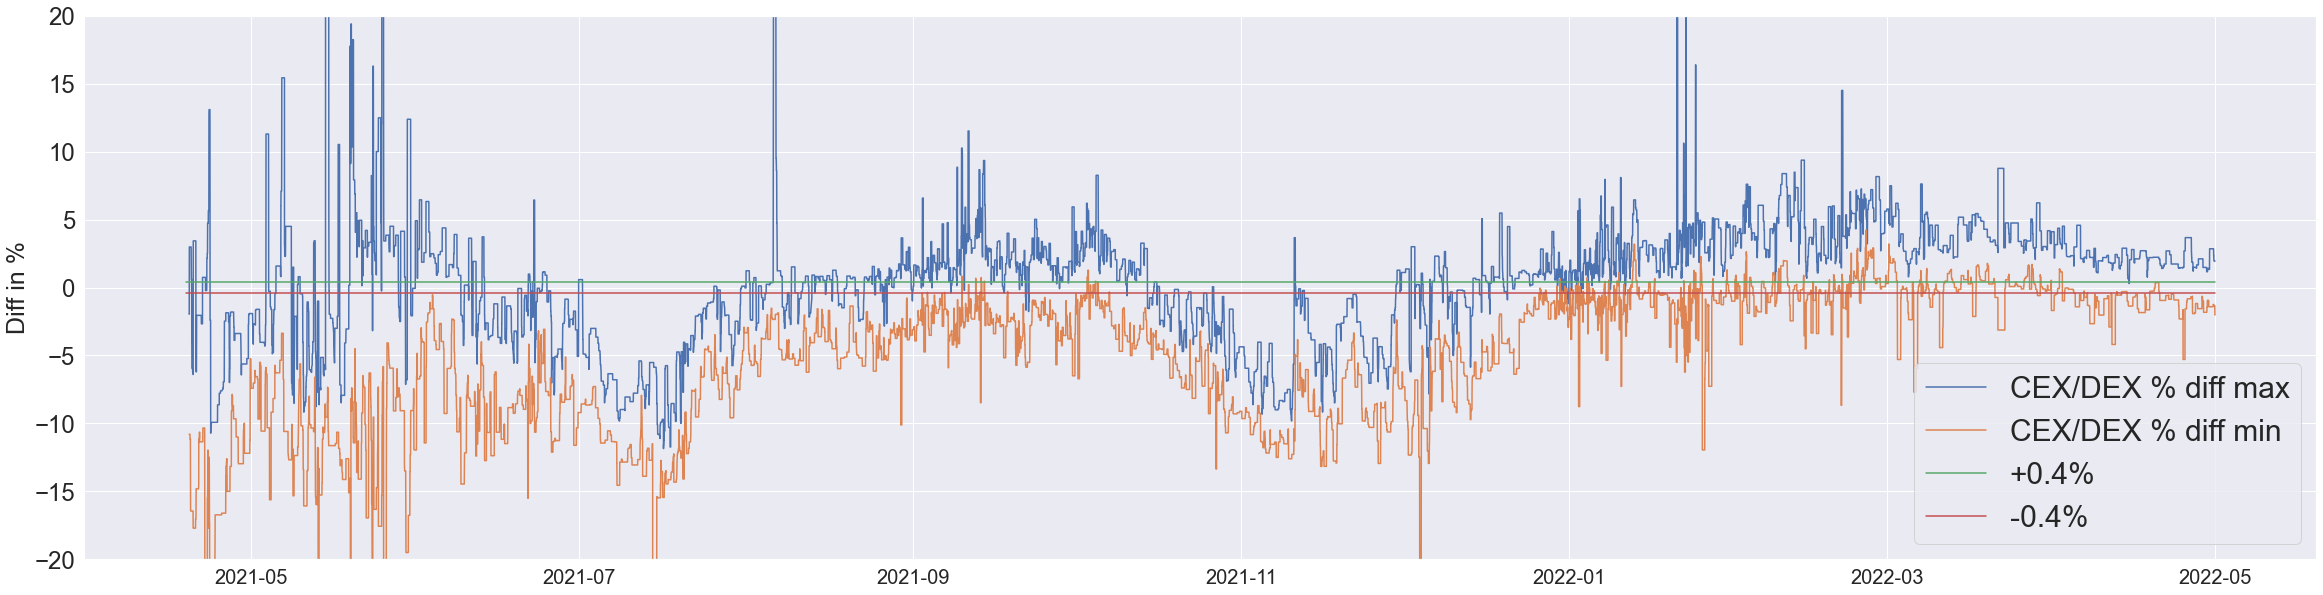

In [299]:
plt.rcParams['figure.figsize'] = [40, 10]
ax = sns.lineplot(price_history["time"], (price_history["cex"]/price_history["dex"]).rolling(100).max()*100-100, label="CEX/DEX % diff max", err_style="bars", ci=68)
ax = sns.lineplot(price_history["time"], (price_history["cex"]/price_history["dex"]).rolling(100).min()*100-100, label="CEX/DEX % diff min", err_style="bars", ci=68)
plt.setp(ax.get_xticklabels(), rotation=0, size=20)
plt.setp(ax.get_yticklabels(), size=24)
ax1 = sns.lineplot([price_history["time"].iloc[0], price_history["time"].iloc[-1]], [+0.4, +0.4], label="+0.4%")
ax1 = sns.lineplot([price_history["time"].iloc[0], price_history["time"].iloc[-1]], [-0.4, -0.4], label="-0.4%")
plt.xlabel("", size=20)
plt.ylabel("Diff in %", size=25)
# plt.yscale("symlog")
plt.ylim([-20, 20])
# plt.xlim([price_history["time"].iloc[0], price_history["time"].iloc[-1]])
plt.legend(prop={'size': 30})
plt.show()